In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import datetime
import itertools
from time import sleep
import os
import seaborn as sns
from itertools import chain

In [2]:
print datetime.datetime.now()
validFilePaths = []
for f in os.listdir("data/anomaly_data"):
    filePath = os.path.join("data/anomaly_data", f)
    if os.path.isdir(filePath):
        continue
    if os.stat(filePath).st_size <= 3:
        continue
    validFilePaths.append(filePath)
    
numF = int(1 * len(validFilePaths))
print 'Using this many files {0}'.format(numF)
validFilePaths = np.random.choice(validFilePaths, numF, replace=False)
df_list = (pd.read_csv(f) for f in validFilePaths)
df = pd.concat(df_list, ignore_index=True)
df = df[df['radiant_win'].notnull()]

2017-06-08 23:19:18.833840
Using this many files 4088


In [3]:
df2 = pd.DataFrame(np.loadtxt('data/goodAnomaliesResidual.csv', delimiter = ','), 
                 columns = ["match_id", "residual"])

df = df.merge(df2, left_on='match_id', right_on='match_id')

matchDictionary = {}
heroColumns = [filter(lambda x: z in x, df.columns) for z in ['hero_id']][0]

# for each row, this function will return all the heroes that the match belongs in
# for example, if the match had an AM and Spectre, we should place this match in each of those bags
def heroesForMatch(row):
    pass

In [4]:
df = df[~df['match_id'].duplicated()]

In [5]:
df = df.sort_values(by='residual', ascending=False)

In [34]:
columns = df.columns
numericalFeatures = ['match_id', 'positive_votes', 'negative_votes', 'first_blood_time', 'radiant_win',
                    'duration', 'kills', 'deaths', 'assists', 'kpm', 'kda', 'hero_dmg',
                    'gpm', 'hero_heal', 'xpm', 'totalgold', 'totalxp', 'lasthits', 'denies',
                    'tower_kills', 'courier_kills', 'observer_uses', 'sentry_uses',
                    'ancient_kills', 'camps_stacked', 'abandons', 'residual']
numFeatures = [filter(lambda x: z in x, columns) for z in numericalFeatures]
numFeatures = list(chain(*numFeatures))
df = df[numFeatures]

In [7]:
df['match_id'].values.tolist()

[3215302144,
 3215336448,
 3215364864,
 3215253504,
 3215305472,
 3215230208,
 3215313664,
 3215256064,
 3215498240,
 3215429120,
 3215156736,
 3215262464,
 3215291648,
 3215383296,
 3215268352,
 3215188736,
 3215221248,
 3215213312,
 3215156480,
 3215155456,
 3215398656,
 3215357952,
 3215157760,
 3215455232,
 3215124736,
 3215122432,
 3215252736,
 3215201792,
 3215419392,
 3215242496,
 3215248640,
 3215158016,
 3215418880,
 3215237632,
 3215386880,
 3215445760,
 3215202048,
 3215298048,
 3215255552,
 3215439104,
 3215482112,
 3215180288,
 3215126016,
 3215130880,
 3215312640,
 3215146240,
 3215275776,
 3215107840,
 3215369984,
 3215484416,
 3215108096,
 3215418624,
 3215342848,
 3215449600,
 3215411712,
 3215135744,
 3215473408,
 3215191552,
 3215424768,
 3215122176,
 3215236352,
 3215326976,
 3215439872,
 3215176704,
 3215450112,
 3215412480,
 3215304704,
 3215424000,
 3215460608,
 3215357440,
 3215225344,
 3215399168,
 3215165440,
 3215100160,
 3215292928,
 3215406336,
 3215431680,

In [8]:
df['residual'].values.tolist()

[23.783334732055664,
 20.135766983032227,
 19.46851921081543,
 19.223609924316406,
 18.764724731445312,
 18.490245819091797,
 17.277061462402344,
 16.947734832763672,
 16.942398071289062,
 16.77090072631836,
 16.555482864379883,
 16.226909637451172,
 15.990052223205566,
 15.902778625488281,
 15.902181625366211,
 15.423715591430664,
 14.709556579589844,
 14.64592456817627,
 14.618253707885742,
 14.335704803466797,
 14.105602264404297,
 14.096576690673828,
 14.056424140930176,
 13.982555389404297,
 13.970139503479004,
 13.891220092773438,
 13.761789321899414,
 13.733879089355469,
 13.663458824157715,
 13.59416389465332,
 13.353803634643555,
 13.22453784942627,
 13.182890892028809,
 13.149872779846191,
 13.004798889160156,
 12.826828956604004,
 12.745077133178711,
 12.738612174987793,
 12.71006965637207,
 12.571928024291992,
 12.549835205078125,
 12.524263381958008,
 12.452695846557617,
 12.317193984985352,
 12.31189250946045,
 12.143924713134766,
 11.965354919433594,
 11.948304176330566,

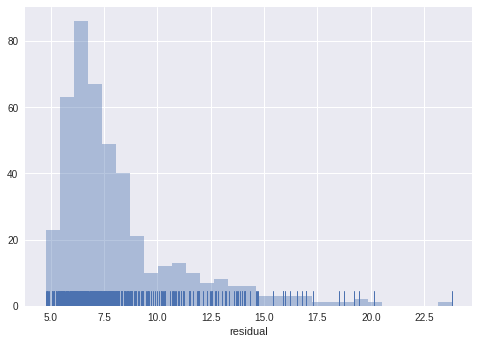

In [9]:
sns.distplot(df['residual'],  kde=False, rug=True)
plt.show()

In [10]:
len(df)

440

In [11]:
plt.close()

In [12]:
residuals = df['residual'].values.tolist()

In [13]:
np.max(residuals) - np.min(residuals)

19.017492294311523

In [14]:
df['residual']

47     23.783335
307    20.135767
79     19.468519
74     19.223610
59     18.764725
81     18.490246
181    17.277061
144    16.947735
64     16.942398
143    16.770901
41     16.555483
402    16.226910
277    15.990052
319    15.902779
120    15.902182
243    15.423716
303    14.709557
14     14.645925
45     14.618254
431    14.335705
202    14.105602
352    14.096577
190    14.056424
232    13.982555
332    13.970140
129    13.891220
292    13.761789
54     13.733879
411    13.663459
245    13.594164
         ...    
147     5.535788
237     5.511476
385     5.465705
173     5.460803
27      5.458718
373     5.451179
281     5.441486
289     5.394897
156     5.386751
150     5.354434
162     5.345767
35      5.336103
377     5.320559
392     5.304674
76      5.253036
428     5.251566
403     5.249150
66      5.163885
178     5.144548
146     5.137314
139     5.134398
434     5.116675
410     5.078004
148     5.074884
218     5.045971
0       4.927567
189     4.892761
126     4.8457

In [15]:
def RadiantDireDifference(row, column):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    radiantSum = 0
    direSum = 0
    for pos in poss:
        radiantSum += row['radiant_'+ pos + '_' + column]
        direSum += row['dire_'+ pos + '_' + column]
    return radiantSum - direSum

def reject_outliers(data, m=1.5):
    return abs(data - np.mean(data)) < m * np.std(data)


def heroKDAdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] + \
                        row[fac + '_' + pos + '_assists'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKDdeficit(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = value
    return returnVal

def heroKD(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_kills'] - \
                        row[fac + '_' + pos + '_deaths']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

def heroGoldSpent(row):
    faction = ['radiant', 'dire']
    poss = ['pos1', 'pos2', 'pos3', 'pos4', 'pos5']
    largestAbsoluteSoFar = -1
    returnVal = -1
    for pos in poss:
        for fac in faction:
            value = row[fac + '_' + pos + '_gold_spent']
            if abs(value) >= largestAbsoluteSoFar:
                largestAbsoluteSoFar = abs(value)
                returnVal = int(pos[3:4])
    return returnVal

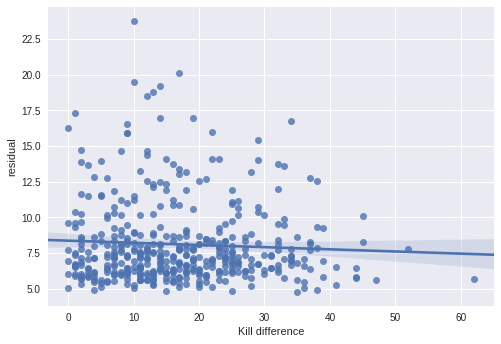

In [16]:
kill_difference = np.abs(df.apply(RadiantDireDifference, args=('kills',), axis=1))
sns.regplot(kill_difference, df['residual'])
ax = plt.gca()
ax.set_xlabel("Kill difference")
plt.show()

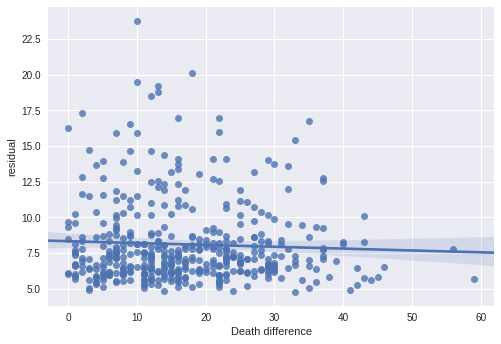

In [17]:
death_difference = df.apply(RadiantDireDifference, args=('deaths',), axis=1)
sns.regplot(np.abs(death_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("Death difference")
plt.show()

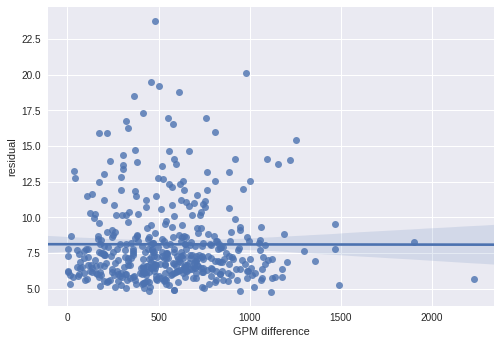

In [18]:
gold_difference = df.apply(RadiantDireDifference, args=('gpm',), axis=1)
above_ = np.abs(gold_difference) <= 5000

indices = np.where(above_)[0]
sns.regplot(np.abs(gold_difference)[above_], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("GPM difference")
plt.show()

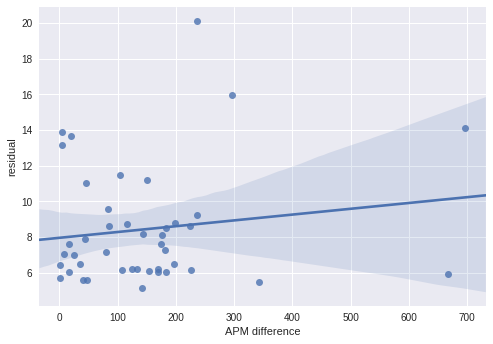

In [19]:
apm_difference = df.apply(RadiantDireDifference, args=('apm',), axis=1)
sns.regplot(np.abs(apm_difference), df['residual'])
ax = plt.gca()
ax.set_xlabel("APM difference")
plt.show()

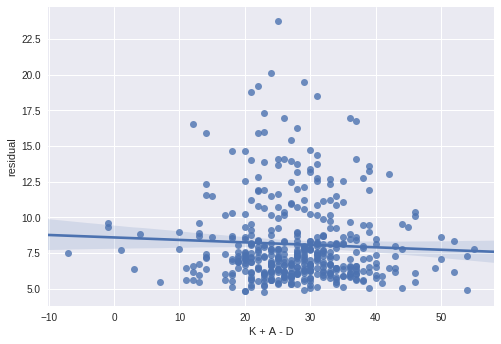

In [20]:
kda = df.apply(heroKDAdeficit, axis=1)
sns.regplot(kda, df['residual'])
ax = plt.gca()
ax.set_xlabel("K + A - D")
plt.show()

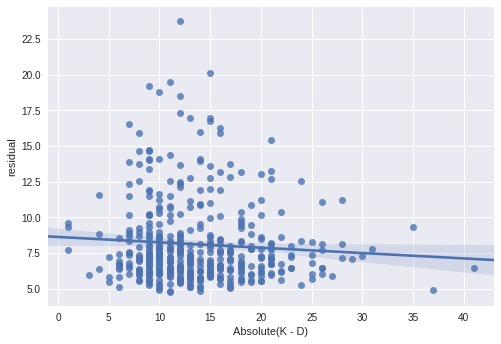

In [21]:
kd = df.apply(heroKDdeficit, axis=1)
sns.regplot(np.abs(kd), df['residual'])
ax = plt.gca()
ax.set_xlabel("Absolute(K - D)")
plt.show()

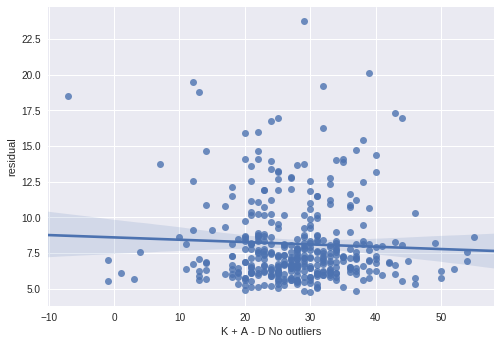

In [22]:
kda = df.apply(heroKDAdeficit, axis=1)
kda_mean = np.mean(kda)
kda_std = np.std(kda)
indices = np.where(np.logical_and(kda <= kda_mean + 1.5*kda_std, kda >= kda_mean-1.5*kda_std))[0]
sns.regplot(kda[indices], df['residual'].iloc[indices])
ax = plt.gca()
ax.set_xlabel("K + A - D No outliers")
plt.show()

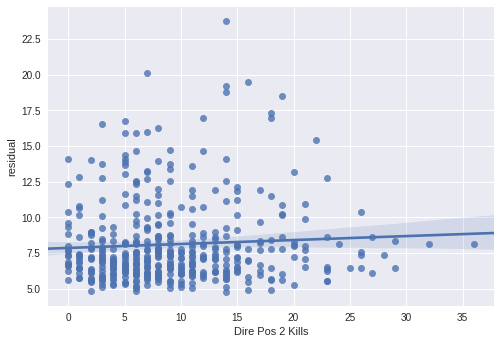

In [23]:
sns.regplot(df['dire_pos2_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Dire Pos 2 Kills")
plt.show()

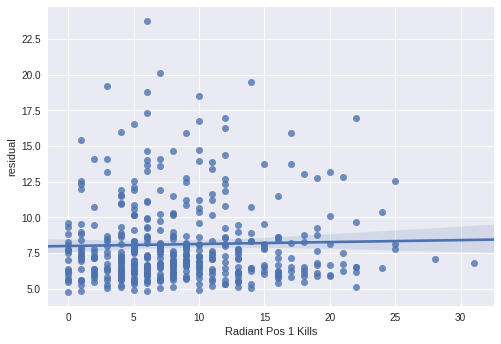

In [24]:
sns.regplot(df['radiant_pos1_kills'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills")
plt.show()

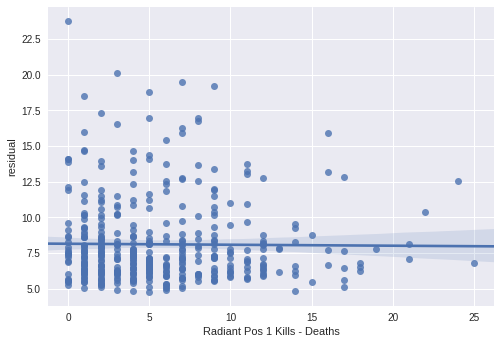

In [25]:
sns.regplot(np.abs(df['radiant_pos1_kills'] - df['radiant_pos1_deaths']), df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 1 Kills - Deaths")
plt.show()

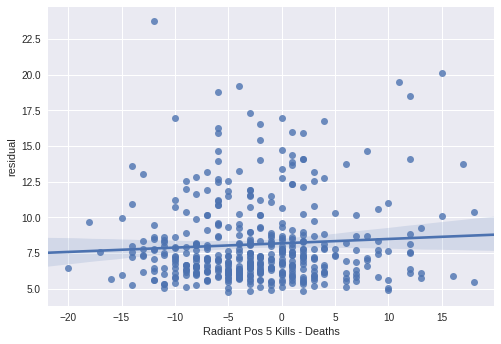

In [26]:
sns.regplot(df['radiant_pos5_kills'] - df['radiant_pos5_deaths'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Radiant Pos 5 Kills - Deaths")
plt.show()

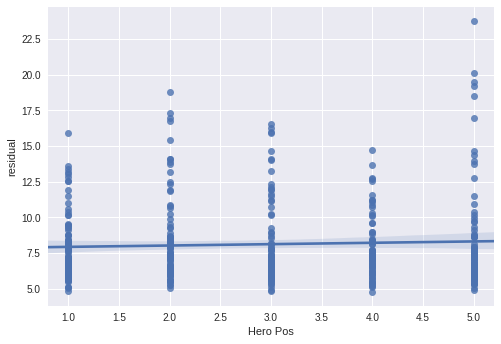

In [27]:
sns.regplot(df.apply(heroKD, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Hero Pos")
plt.show()

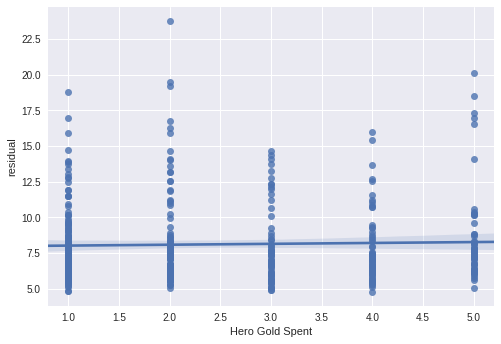

In [28]:
sns.regplot(df.apply(heroGoldSpent, axis=1), df['residual'])
ax = plt.gca()
ax.set_xlabel("Hero Gold Spent")
plt.show()

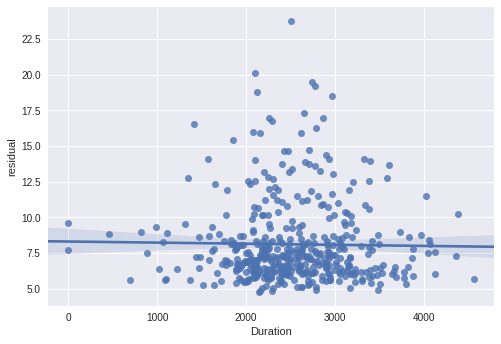

In [29]:
sns.regplot(df['duration'], df['residual'])
ax = plt.gca()
ax.set_xlabel("Duration")
plt.show()

In [30]:
df[df['residual'] > 17]

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
47,3215302144,0,0,133,True,2500,NaN,NaN,8,NaN,...,0,0,0,0,0,0,0,0,0,23.783335
307,3215336448,0,0,118,True,2104,30.0,0.0,4,173.0,...,0,0,0,0,0,0,0,0,0,20.135767
79,3215364864,0,0,516,True,2736,NaN,NaN,1,NaN,...,0,0,0,0,0,0,0,0,0,19.468519
74,3215253504,0,0,259,False,2775,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,1,0,19.223610
59,3215305472,0,0,152,True,2121,NaN,NaN,3,NaN,...,0,1,0,0,0,0,0,0,0,18.764725
81,3215230208,0,0,119,True,2966,NaN,NaN,7,NaN,...,0,0,0,0,0,0,0,0,0,18.490246
181,3215313664,0,0,231,True,2650,NaN,NaN,4,NaN,...,0,0,0,0,0,0,0,0,0,17.277061


In [31]:
df[df['residual'] < 7.5].sample(10, random_state=1)

,match_id,positive_votes,negative_votes,first_blood_time,radiant_win,duration,dire_pos1_ancient_kills,dire_pos1_courier_kills,dire_pos1_kills,dire_pos1_neutral_kills,...,dire_pos2_abandons,dire_pos3_abandons,dire_pos4_abandons,dire_pos5_abandons,radiant_pos1_abandons,radiant_pos2_abandons,radiant_pos3_abandons,radiant_pos4_abandons,radiant_pos5_abandons,residual
390,3215095296,0,0,10,True,2576,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,6.769508
197,3215159040,0,0,0,False,2147,NaN,NaN,13,NaN,...,0,0,0,0,0,0,0,0,0,4.765842
43,3215438848,0,0,70,True,2940,NaN,NaN,5,NaN,...,0,0,0,0,0,0,0,1,0,5.615639
281,3215137280,0,0,82,True,2392,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,5.441486
16,3215271168,0,0,250,True,2365,NaN,NaN,5,NaN,...,0,0,0,1,0,0,0,0,0,6.599493
27,3215099648,0,0,238,True,1981,NaN,NaN,0,NaN,...,0,0,0,0,0,1,0,0,0,5.458718
304,3215121920,0,0,5,True,2015,NaN,NaN,0,NaN,...,0,0,0,0,0,0,0,0,0,6.901570
115,3215327488,0,0,62,False,2595,NaN,NaN,2,NaN,...,0,0,0,0,0,0,0,0,0,6.248038
76,3215325696,0,0,10,True,2694,NaN,NaN,11,NaN,...,0,0,0,0,0,0,0,0,0,5.253036
65,3215126272,0,0,94,False,2239,NaN,NaN,0,NaN,...,0,0,0,1,0,0,0,0,0,7.415165


In [32]:
biggestAnom = np.loadtxt('data/anomalies.csv', delimiter = ',')
theirOutput = np.loadtxt('data/output.csv', delimiter = ",")

In [35]:
def whichIndex(row1, row2):
    largestError = -1
    index = -1
    for i in range(1, len(row1)):
        if abs(row1[i] - row2[i]) > largestError:
            largestError = abs(row1[i] - row2[i])
            index = i
    return index

for i in range(len(biggestAnom)):
    index = whichIndex(biggestAnom[i, :], theirOutput[i, :])
    df.columns[index]
    print biggestAnom[i, 0], df.columns[index], biggestAnom[i, index], theirOutput[i, index]

3215309056.0 dire_pos5_courier_kills 0.995847344398 -0.000755190849304
3215442688.0 dire_pos5_denies 0.69792932272 -0.00183379650116
3215369984.0 dire_pos5_gpm 0.98532474041 -0.00287616252899
3215117056.0 dire_pos4_tower_kills 0.976650416851 -0.00102615356445
3215475712.0 dire_pos4_totalgold 0.989591896534 -0.00103939697146
3215295232.0 dire_pos5_totalxp 0.805929481983 -0.000198841094971
3215255040.0 dire_pos4_gpm 0.740376114845 0.000161051750183
3215132672.0 dire_pos2_tower_kills 0.977136254311 0.0010951757431
3215353856.0 radiant_pos2_gpm 0.746239602566 -0.000252962112427
3215424768.0 dire_pos1_denies 0.809497892857 -0.000454902648926
